In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers,optimizers,losses,regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Hyper Parameters


In [2]:
columns=["files","labels"]
LABELS=['fire', 'fog', 'No fire', 'smoke', 'sunset']
PATH="D:\\df\\ai\\fire"
IMAGE_WIDTH=256
IMAGE_HEIGHT = 256
BACH_SIZE= 8
LR=1e-4
CSV_PATH="../history.csv"
MODEL_SAVE="../new"
N_CLASSES=len(LABELS)
N_EPOCHS=150
LAMBDA=0.2

# Data Preparation

In [12]:

def load_data(path,train=True):
    images=[]
    labels=[]

    if train :
        df=pd.read_csv("../data/train.csv",names=columns,header=1)
    else:
        df=pd.read_csv("../data/test.csv",names=columns,header=1)
    
    for _,row in df.iterrows():
        label=row["labels"]
        labels.append(LABELS.index(label))
        if train:
            images.append(os.path.join(path,"train",label,row["files"]))
        else :
            images.append(os.path.join(path,"test",label,row["files"]))
    return images,labels
    
def load_dataset(path,test_size=0.1,random_state=18):
    images,labels=load_data(path)
    test_images,test_labels=load_data(path,train=False)
    train_images,val_images=train_test_split(images,test_size=test_size,random_state=random_state)
    train_labels,val_labels=train_test_split(labels,test_size=test_size,random_state=random_state)

    return (train_images,train_labels),(val_images,val_labels),(test_images,test_labels)


def read_images(image_path,label):
    image=tf.io.read_file(image_path)
    image=tf.io.decode_jpeg(image)
    height,width,channels=image.shape
    image=tf.image.resize(image,(IMAGE_HEIGHT,IMAGE_WIDTH),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    if channels==1:
        image=tf.image.grayscale_to_rgb(image)
    image=np.array(image,dtype=np.float32)
    if channels==4:
        image = image[:,:,:3]
    
    #Normalization [-1,1]
    image=(image/255)

    one_hot=np.zeros(N_CLASSES,dtype=np.float32)
    one_hot[label]=1
     
    return image,one_hot
def load_tensors(images,labels):
    images,labels=tf.numpy_function(read_images,[images,labels],[tf.float32,tf.float32])
    return images,labels

    
def tfData(images,labels,batch_size=BACH_SIZE):
    ds=tf.data.Dataset.from_tensor_slices((images,labels))
    ds=ds.map(load_tensors,num_parallel_calls=tf.data.AUTOTUNE)
    ds=ds.cache()
    ds=ds.batch(batch_size)
    ds=ds.prefetch(tf.data.AUTOTUNE)
    return ds

(train_images,train_labels),(val_images,val_labels),(test_images,test_labels)=load_dataset(PATH)

ds_train=tfData(train_images,train_labels)
ds_val=tfData(val_images,val_labels)

print(f"train :{len(train_images)}")
print(f"val   :{len(val_images)}")

train :893
val   :100


# Build Model

In [16]:
class CNNBlock(layers.Layer):
    def __init__(self,filter_size,channels,padding="same",filter_stride=1,pool_info=None):
        super(CNNBlock,self).__init__()
        self.dopool=False
        self.conv=layers.Conv2D(channels,filter_size,filter_stride,padding=padding)
        self.batch=layers.BatchNormalization()
        if pool_info != None:
            self.pooling=layers.MaxPool2D(pool_info[0],pool_info[1])
            self.dopool=True
    
    def call(self,inputs,training=False):
        x=self.conv(inputs)
        x=self.batch(x,training=training)
        x=tf.nn.relu(x)
        if self.dopool:
            x=self.pooling(x)
        return x




class AlexNet(tf.keras.Model):
    def __init__(self):
        super(AlexNet,self).__init__()

        self.cnn1=CNNBlock((11,11),96,'valid',4,((3,3),2))
        self.cnn2=CNNBlock((5,5),256,pool_info=((3,3),2))
        self.cnn3=CNNBlock((3,3),384)
        self.cnn4=CNNBlock((3,3),384)
        self.cnn5=CNNBlock((3,3),256,pool_info=((3,3),2))
        self.outputlayer=layers.Dense(N_CLASSES,activation="softmax")
    def call(self,inputs,training=False):
        x=self.cnn1(inputs,training)
        x=self.cnn2(x,training=training)
        x=self.cnn3(x,training=training)
        x=self.cnn4(x,training=training)
        x=self.cnn5(x,training=training)
        x=layers.Flatten()(x)
        x=self.outputlayer(x,training=training)
        return x
    def architecture(self):
        x=keras.Input((256,256,3))
        model=tf.keras.Model(inputs=[x],outputs=self.call(x))
        return model.summary()
m=AlexNet()
print(m.architecture())

model=AlexNet()
inputs=keras.Input((IMAGE_HEIGHT,IMAGE_WIDTH,3))
outputs=model(inputs)


model=tf.keras.Model(inputs=inputs,outputs=outputs)
model.summary()
model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(LR), metrics=[keras.metrics.CategoricalAccuracy()]
    )



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 cnn_block (CNNBlock)        (None, 30, 30, 96)        35328     
                                                                 
 cnn_block_1 (CNNBlock)      (None, 14, 14, 256)       615680    
                                                                 
 cnn_block_2 (CNNBlock)      (None, 14, 14, 384)       886656    
                                                                 
 cnn_block_3 (CNNBlock)      (None, 14, 14, 384)       1329024   
                                                                 
 cnn_block_4 (CNNBlock)      (None, 6, 6, 256)         886016    
                                                                 
 flatten (Flatten)           (None, 9216)              0     

# Training

In [6]:
callbacks = [
        ModelCheckpoint(MODEL_SAVE, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False,min_delta=0.01),
        CSVLogger(CSV_PATH,append=False)
    ]

history=model.fit(
        ds_train,
        epochs=N_EPOCHS,
        validation_data=ds_val,
        verbose=1,
        callbacks=callbacks
    )

Epoch 1/150
112/112 [==============================] - ETA: 0s - loss: 0.6743 - categorical_accuracy: 0.7895
Epoch 1: val_loss improved from inf to 2.24251, saving model to ..\new


INFO:tensorflow:Assets written to: ..\new\assets


INFO:tensorflow:Assets written to: ..\new\assets


112/112 [==============================] - 17s 108ms/step - loss: 0.6743 - categorical_accuracy: 0.7895 - val_loss: 2.2425 - val_categorical_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 2/150
112/112 [==============================] - ETA: 0s - loss: 0.2380 - categorical_accuracy: 0.9149
Epoch 2: val_loss did not improve from 2.24251
112/112 [==============================] - 6s 52ms/step - loss: 0.2380 - categorical_accuracy: 0.9149 - val_loss: 2.9046 - val_categorical_accuracy: 0.1000 - lr: 1.0000e-04
Epoch 3/150
112/112 [==============================] - ETA: 0s - loss: 0.1059 - categorical_accuracy: 0.9630
Epoch 3: val_loss improved from 2.24251 to 1.62122, saving model to ..\new


INFO:tensorflow:Assets written to: ..\new\assets


INFO:tensorflow:Assets written to: ..\new\assets


112/112 [==============================] - 9s 78ms/step - loss: 0.1059 - categorical_accuracy: 0.9630 - val_loss: 1.6212 - val_categorical_accuracy: 0.4100 - lr: 1.0000e-04
Epoch 4/150
112/112 [==============================] - ETA: 0s - loss: 0.0398 - categorical_accuracy: 0.9933
Epoch 4: val_loss improved from 1.62122 to 0.93677, saving model to ..\new


INFO:tensorflow:Assets written to: ..\new\assets


INFO:tensorflow:Assets written to: ..\new\assets


112/112 [==============================] - 9s 76ms/step - loss: 0.0398 - categorical_accuracy: 0.9933 - val_loss: 0.9368 - val_categorical_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 5/150
111/112 [============================>.] - ETA: 0s - loss: 0.0274 - categorical_accuracy: 0.9944
Epoch 5: val_loss improved from 0.93677 to 0.30557, saving model to ..\new


INFO:tensorflow:Assets written to: ..\new\assets


INFO:tensorflow:Assets written to: ..\new\assets


112/112 [==============================] - 9s 78ms/step - loss: 0.0272 - categorical_accuracy: 0.9944 - val_loss: 0.3056 - val_categorical_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 6/150
112/112 [==============================] - ETA: 0s - loss: 0.0060 - categorical_accuracy: 1.0000
Epoch 6: val_loss improved from 0.30557 to 0.16964, saving model to ..\new


INFO:tensorflow:Assets written to: ..\new\assets


INFO:tensorflow:Assets written to: ..\new\assets


112/112 [==============================] - 9s 78ms/step - loss: 0.0060 - categorical_accuracy: 1.0000 - val_loss: 0.1696 - val_categorical_accuracy: 0.9300 - lr: 1.0000e-04
Epoch 7/150
112/112 [==============================] - ETA: 0s - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 7: val_loss improved from 0.16964 to 0.12919, saving model to ..\new


INFO:tensorflow:Assets written to: ..\new\assets


INFO:tensorflow:Assets written to: ..\new\assets


112/112 [==============================] - 9s 79ms/step - loss: 0.0019 - categorical_accuracy: 1.0000 - val_loss: 0.1292 - val_categorical_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 8/150
112/112 [==============================] - ETA: 0s - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 8: val_loss improved from 0.12919 to 0.12338, saving model to ..\new


INFO:tensorflow:Assets written to: ..\new\assets


INFO:tensorflow:Assets written to: ..\new\assets


112/112 [==============================] - 9s 77ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.1234 - val_categorical_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 9/150
112/112 [==============================] - ETA: 0s - loss: 7.8148e-04 - categorical_accuracy: 1.0000
Epoch 9: val_loss improved from 0.12338 to 0.12239, saving model to ..\new


INFO:tensorflow:Assets written to: ..\new\assets


INFO:tensorflow:Assets written to: ..\new\assets


112/112 [==============================] - 9s 76ms/step - loss: 7.8148e-04 - categorical_accuracy: 1.0000 - val_loss: 0.1224 - val_categorical_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 10/150
111/112 [============================>.] - ETA: 0s - loss: 6.2856e-04 - categorical_accuracy: 1.0000
Epoch 10: val_loss improved from 0.12239 to 0.12193, saving model to ..\new


INFO:tensorflow:Assets written to: ..\new\assets


INFO:tensorflow:Assets written to: ..\new\assets


112/112 [==============================] - 9s 81ms/step - loss: 6.2618e-04 - categorical_accuracy: 1.0000 - val_loss: 0.1219 - val_categorical_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 11/150
111/112 [============================>.] - ETA: 0s - loss: 5.2678e-04 - categorical_accuracy: 1.0000
Epoch 11: val_loss did not improve from 0.12193
112/112 [==============================] - 6s 54ms/step - loss: 5.2487e-04 - categorical_accuracy: 1.0000 - val_loss: 0.1221 - val_categorical_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 12/150
111/112 [============================>.] - ETA: 0s - loss: 4.5344e-04 - categorical_accuracy: 1.0000
Epoch 12: val_loss did not improve from 0.12193
112/112 [==============================] - 6s 54ms/step - loss: 4.5186e-04 - categorical_accuracy: 1.0000 - val_loss: 0.1223 - val_categorical_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 13/150
111/112 [============================>.] - ETA: 0s - loss: 3.9690e-04 - categorical_accuracy: 1.0000
Epoch 13: val_loss did not impr

# Evaluation

# training history

['epoch', 'categorical_accuracy', 'loss', 'lr', 'val_categorical_accuracy', 'val_loss']


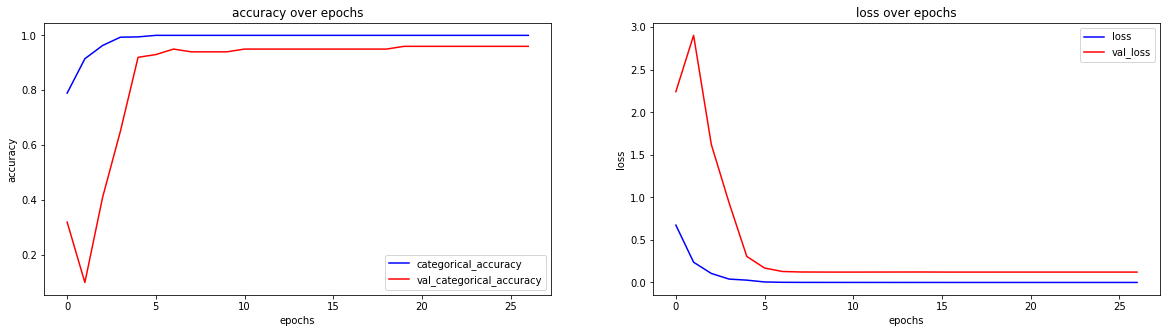

In [7]:
df=pd.read_csv("../history.csv")
x=np.arange(df.shape[0])

print(list(df.keys()))
infos=[["accuracy","categorical_accuracy","val_categorical_accuracy"],["loss","loss","val_loss"]]

fig,axes=plt.subplots(1,2,figsize=(20,5))
for i in range(0,2):
    axes[i].set_title(f"{infos[i][0]} over epochs")
    axes[i].set_xlabel("epochs")
    axes[i].set_ylabel(infos[i][0])
    axes[i].plot(x,df[infos[i][1]],label=infos[i][1],c="blue")
    axes[i].plot(x,df[infos[i][2]],label=infos[i][2],c="red")
    axes[i].legend()

## Metrics for testing

In [14]:
model=tf.keras.models.load_model(MODEL_SAVE)
ds_test=tfData(test_images,test_labels,1)
ds_test = iter(ds_test)
labels=[]
real_bboxs=[]
preds=[]
for images,label in ds_test:
    pred_label=model.predict(images,verbose=0)
    preds.append(np.argmax(pred_label))
    labels.append(np.argmax(label))
print(f"accuracy score is :{accuracy_score(labels,preds):.2f}")    
print(f"f1       score is :{f1_score(labels,preds,average='micro'):.2f}")    


accuracy score is :0.96
f1       score is :0.96
